In [1]:
import mappy as mp
import json, re, os
from subprocess import call, check_output

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px

In [5]:
samples = [
    "test",
]

## tss visualization

In [3]:
samples = [
    "IRF1-FP2h-rep1",
    "IRF1-noFP-rep1",
    "MYC-FP2h-rep1",
    "MYC-noFP-rep1",
    # "1-y-scaRNA-FP",
]

In [ ]:
def call_peak(sample):
    cmd = f"makeTagDirectory ./tagdir ../data/interim/scaRNA/bed/{sample}_frags.sort.mRNA.bed -format bed -sspe -keepAll -genome ~/REF/hg19/Sequence/Bowtie2Index/hg19.fa"
    call(cmd, shell=True)
    cmd = (
        f"findPeaks ./tagdir -style tss -o ../data/interim/scaRNA/peak/{sample}.tsspeak.bed -size 1"
    )
    call(cmd, shell=True)
    call("rm -rf ./tagdir", shell=True)

In [ ]:
for sample in samples:
    call_peak(sample)

In [3]:
genes = pd.read_csv("../data/ref/scaRNA/ucsc.knowngene.hg19.txt", sep="\t")
genes["tss"] = genes["txStart"].where(genes["strand"] == "+", genes["txEnd"])
genes["tss-500"] = genes["tss"] - 500
genes["tss-500"] = genes["tss-500"].where(genes["tss-500"] >= 0, 0)
genes["tss+500"] = genes["tss"] + 500


# b = genes[['chrom','tss-500','tss+500','#name','tss','strand']]
# b.drop_duplicates(['chrom','tss-500','tss+500',]).to_csv('../data/ref/scaRNA/ucsc.gene.bed', sep='\t',index=False,header=False)
def get_annotated_tss(chrom, start, strand):
    # chrom, start, strand = row['chr'], row['start'], row['strand']
    subdf = genes[
        (genes["chrom"] == chrom)
        & (genes["tss-500"] <= start)
        & (genes["tss+500"] >= start)
        & (genes["strand"] == strand)
    ]
    if len(subdf) == 0:
        return 0, 0
    else:
        return subdf.iloc[0]["tss"], len(subdf)

In [4]:
def get_observed_tss(sample):
    chroms = [f"chr{i}" for i in range(1, 23)]
    tss_peak = pd.read_csv(
        f"../data/interim/scaRNA/peak/{sample}.tsspeak.bed", sep="\t", skiprows=31
    )
    tss_peak = tss_peak[tss_peak["chr"].isin(chroms)]
    tss_peak = tss_peak[["chr", "start", "end", "strand", "findPeaks Score"]]
    tss_peak = tss_peak.sort_values(by="findPeaks Score", ascending=False)
    tss_distance = tss_peak.copy()
    tss_distance = tss_distance.reset_index(drop=True)
    from multiprocessing import Pool

    with Pool(40) as p:
        a = p.starmap(get_annotated_tss, tss_distance[["chr", "start", "strand"]].values)
    a = pd.DataFrame(a, columns=["annotated_tss", "annotated_tss_count"])
    tss_distance = pd.concat([tss_distance, a], axis=1)
    tss_distance = tss_distance[tss_distance["annotated_tss_count"] == 1]
    tss_distance["distance"] = tss_distance["start"] - tss_distance["annotated_tss"]
    tss_distance.to_csv(
        f"../data/interim/scaRNA/peak/{sample}_observed_tss.txt", sep="\t", index=False
    )
    tss_count = tss_distance["distance"].value_counts().to_frame(name="count")
    tss_count["precent"] = tss_count["count"] / tss_count["count"].sum() * 100
    tss_count["position"] = tss_count.index
    tss_count = tss_count.sort_values(by="position")
    tss_count.to_csv(
        f"../data/interim/scaRNA/peak/{sample}_tss_distance.txt", sep="\t", index=False
    )

In [7]:
for sample in samples:
    get_observed_tss(sample)

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [5]:
tss_distance = []
for sample in samples:
    df = pd.read_csv(f"../data/interim/scaRNA/peak/{sample}_tss_distance.txt", sep="\t")
    df["sample"] = sample
    tss_distance.append(df)
tss_distance = pd.concat(tss_distance, ignore_index=True)

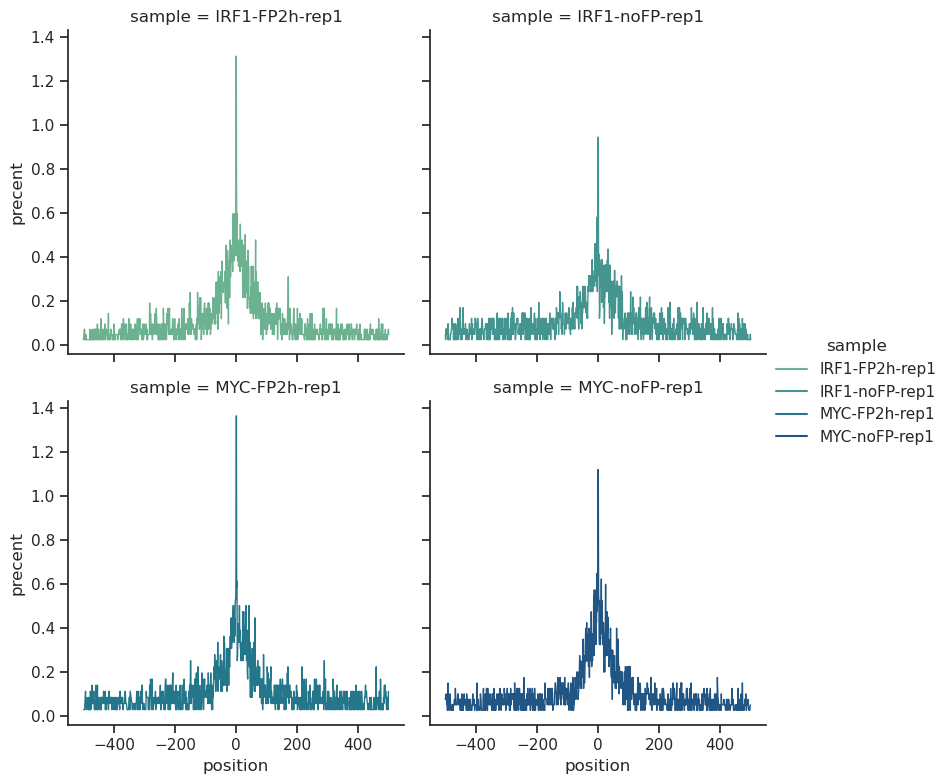

In [7]:
import seaborn as sns

sns.set_theme(style="ticks")

sns.relplot(
    x="position",
    y="precent",
    col="sample",
    data=tss_distance,
    col_wrap=2,
    kind="line",
    palette="crest",
    linewidth=1,
    hue="sample",
    height=4,
)

In [5]:
def meta_profile(sample):
    cmd = f"bedtools intersect -a ../data/interim/scaRNA/bed/{sample}_frags.sort.mRNA.bed -b ../data/ref/scaRNA/ucsc.gene.bed -wo > ../data/interim/scaRNA/bed/{sample}_ucsc_intersc.bed"
    call(cmd, shell=True)
    df = pd.read_csv(f"../data/interim/scaRNA/bed/{sample}_ucsc_intersc.bed", sep="\t", header=None)
    chroms = [f"chr{i}" for i in range(1, 23)]
    df = df[df[0].isin(chroms)].copy()
    df["tss"] = df[1].where(df[5] == "+", df[2])
    df["tes"] = df[2].where(df[5] == "+", df[1])
    df["tss_distance"] = df["tss"] - df[10]
    df["pause_distance"] = df["tes"] - df[10]
    df["tss_distance"] = df["tss_distance"].where(df[11] == "+", -df["tss_distance"])
    df["pause_distance"] = df["pause_distance"].where(df[11] == "+", -df["pause_distance"])
    df["sense"] = "sense"
    df["sense"] = df["sense"].where(df[5] == df[11], "antisense")
    # antisense_df = df[df['sense'] == 'antisense'].copy()
    # sense_df = df[df['sense'] == 'sense'].copy()

    tss_df = df[[6, 10, "sense", "tss_distance"]].value_counts().to_frame()
    tss_df = tss_df.reset_index()
    tss_df[0] = tss_df[0].where(tss_df[0] < 3, 3)
    tss_df = tss_df[["tss_distance", "sense"]].value_counts().to_frame(name="count")
    tss_df = tss_df.reset_index()
    tss_df["precent"] = tss_df["count"] / tss_df["count"].sum() * 100
    tss_df["precent"] = tss_df["precent"].where(tss_df["sense"] == "sense", -tss_df["precent"])
    tss_df = tss_df.sort_values(by="tss_distance")
    tss_df = tss_df[(tss_df["tss_distance"] > -500) & (tss_df["tss_distance"] < 500)].copy()
    tss_df["type"] = "Initiation " + tss_df["sense"]
    tss_df["sample"] = sample
    tss_df = tss_df.rename(columns={"tss_distance": "position"})

    pause_df = df[[6, 10, "sense", "pause_distance"]].value_counts().to_frame()
    pause_df = pause_df.reset_index()
    pause_df[0] = pause_df[0].where(pause_df[0] < 3, 3)
    pause_df = pause_df[["pause_distance", "sense"]].value_counts().to_frame(name="count")
    pause_df = pause_df.reset_index()
    pause_df["precent"] = pause_df["count"] / pause_df["count"].sum() * 100
    pause_df["precent"] = pause_df["precent"].where(
        pause_df["sense"] == "sense", -pause_df["precent"]
    )
    pause_df = pause_df.sort_values(by="pause_distance")
    pause_df = pause_df[
        (pause_df["pause_distance"] > -500) & (pause_df["pause_distance"] < 500)
    ].copy()
    pause_df["type"] = "Pausing " + pause_df["sense"]
    pause_df["sample"] = sample
    pause_df = pause_df.rename(columns={"pause_distance": "position"})

    meta_df = pd.concat([tss_df, pause_df], ignore_index=True)

    meta_df.to_csv(f"../data/interim/scaRNA/peak/{sample}_meta.txt", sep="\t", index=False)

In [6]:
for sample in samples:
    meta_profile(sample)

In [7]:
meta_df = []
for sample in samples:
    df = pd.read_csv(f"../data/interim/scaRNA/peak/{sample}_meta.txt", sep="\t")
    meta_df.append(df)
meta_df = pd.concat(meta_df, ignore_index=True)

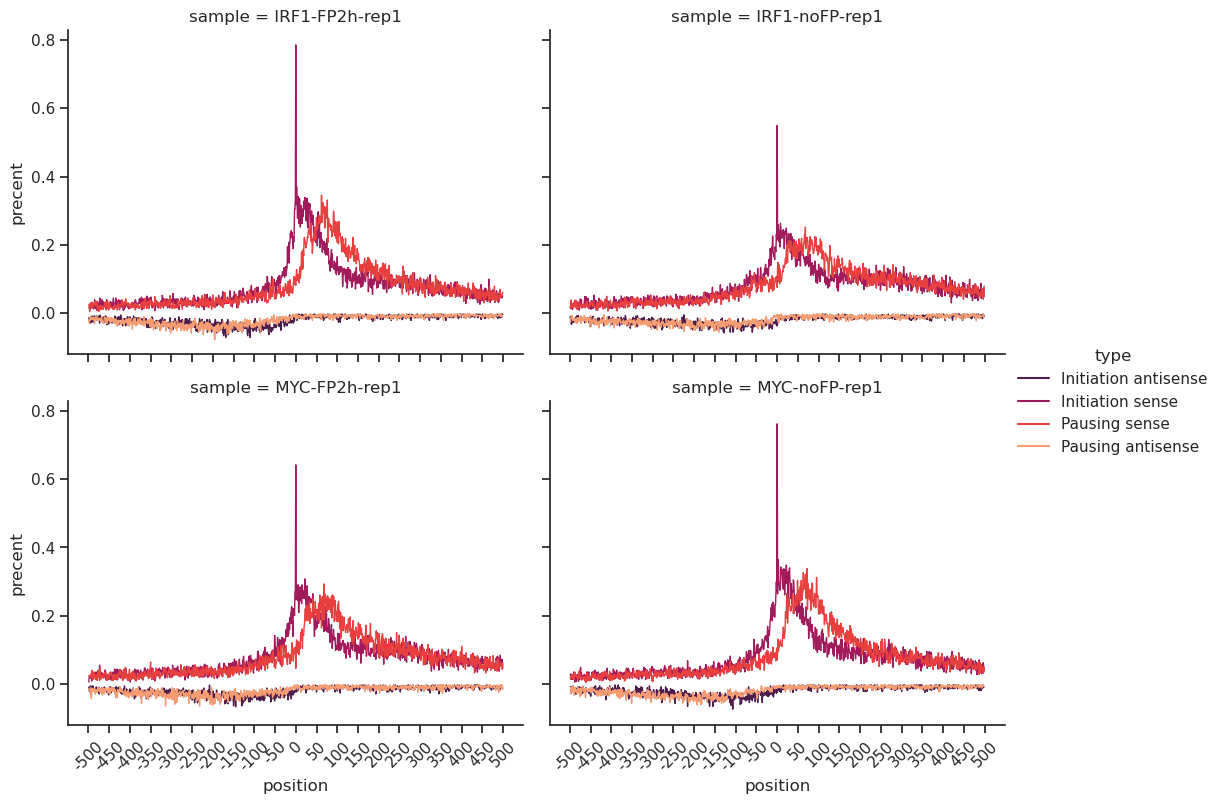

In [8]:
import seaborn as sns

sns.set_theme(style="ticks")

grid = sns.relplot(
    x="position",
    y="precent",
    col="sample",
    data=meta_df,
    col_wrap=2,
    kind="line",
    palette="rocket",
    linewidth=1,
    hue="type",
    height=4,
    aspect=1.3,
)

grid.set(xticks=np.arange(-500, 501, 50))
grid.set_xticklabels(np.arange(-500, 501, 50), rotation=45)

## tes peak

In [4]:
samples = [
    "IRF1-FP2h-rep1",
    "IRF1-noFP-rep1",
    "MYC-FP2h-rep1",
    "MYC-noFP-rep1",
]

In [17]:
def call_peak(sample):
    bed = pd.read_csv(
        f"../data/interim/scaRNA/bed/{sample}_frags.sort.mRNA.bed", sep="\t", header=None
    )
    bed[6] = bed[2].where(bed[5] == "+", bed[2] - 50)
    bed[7] = (bed[2] + 50).where(bed[5] == "+", bed[2])
    bed[[0, 6, 7, 3, 4, 5]].to_csv(
        f"../data/interim/scaRNA/tes/{sample}.tes.50.bed", sep="\t", header=None, index=None
    )
    cmd = f"makeTagDirectory ../data/interim/scaRNA/tes/{sample} ../data/interim/scaRNA/tes/{sample}.tes.50.bed -format bed -sspe -keepAll -genome ~/REF/hg19/Sequence/Bowtie2Index/hg19.fa"
    call(cmd, shell=True)
    cmd = f"findPeaks ../data/interim/scaRNA/tes/{sample} -style tss -o ../data/interim/scaRNA/tes/{sample}.tespeak.bed -size 50"
    call(cmd, shell=True)
    # call('rm -rf ./tagdir', shell=True)

In [20]:
for sample in samples:
    call_peak(sample)

	Will parse file: ../data/interim/scaRNA/tes/IRF1-FP2h-rep1.tes.50.bed
	Custom genome sequence file: /beegfs/home/wangjianhua/REF/hg19/Sequence/Bowtie2Index/hg19.fa

	Creating directory: ../data/interim/scaRNA/tes/IRF1-FP2h-rep1 and removing existing *.tags.tsv

	Reading alignment file ../data/interim/scaRNA/tes/IRF1-FP2h-rep1.tes.50.bed

	Optimizing tag files...
	Estimated genome size = 3093380430
	Estimated average read density = 0.000742 per bp
	Total Tags = 2293847.0
	Total Positions = 102496
	Average tag length = 50.0
	Median tags per position = 1 (ideal: 1)
	Average tags per position = 21.741
	Fragment Length Estimate: 1382
	Peak Width Estimate: 8
		!!! No reliable estimate for peak size
		Setting Peak width estimate to be equal to fragment length estimate
	Autocorrelation quality control metrics:
		Same strand fold enrichment: 7.7
		Diff strand fold enrichment: 1.9
		Same / Diff fold enrichment: 9.6

		Guessing sample is strand specific RNA-Seq
		Setting fragment length estimate

In [ ]:
for sample in samples:
    call(
        f"findMotifsGenome.pl ../data/interim/scaRNA/tes/{sample}.tespeak.bed hg19 ../data/interim/scaRNA/tes/{sample} -size 16 -p 20",
        shell=True,
    )